In [43]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import nltk
import contractions
import re 
import json
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.corpus import stopwords
stop_words = stopwords.words('english')
from nltk.stem.porter import PorterStemmer
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM, GlobalMaxPooling1D, SpatialDropout1D

# Data Exploring

In [13]:
df=pd.read_csv('../data/twitter_training.csv', sep=',', names=['Tweet_ID','Game','target','text'])

In [14]:
df.shape

(74682, 4)

In [15]:
df.head()

,Tweet_ID,Game,target,text
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


In [16]:
df.dropna(axis=0, inplace=True)

In [17]:
df.reset_index(inplace=True)


In [20]:
df = df.drop(['index', 'Tweet_ID'], axis = 1)

In [26]:
with open('../build/labels.json', 'r') as f:
    mapa = json.load(f)
mapa

{'direct': {'Positive': 3, 'Neutral': 2, 'Negative': 1, 'Irrelevant': 0},
 'reverse': {'3': 'Positive',
  '2': 'Neutral',
  '1': 'Negative',
  '0': 'Irrelevant'}}

In [39]:
df["text"] = df['text'].apply(lambda x: str(x))
df["text"] = df.text.apply(lambda x: re.sub('[^A-Za-z0-9 ]+', '', x))
df['text'] = df.text.apply(lambda x: re.sub(r'[^\w\s]', '', x))
df["text"] = df['text'].str.lower()
df['text'] = df['text'].apply(lambda x: contractions.fix(x))
df['target'] = df['target'].apply(lambda x: mapa['direct'][x])
df['text'] = df['text'].apply(lambda x: ' '.join(x.split()))

In [40]:
x = df['text']
y = df['target']

In [41]:
x[23452], y[23452]

('the great awakening they fear us', 0)

In [44]:
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in stop_words]))
    return removed_stop_words

def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

In [54]:
no_stop_words_tweet = remove_stop_words(x)
stemmed_reviews_tweet = get_stemmed_text(no_stop_words_tweet)

AttributeError: 'numpy.ndarray' object has no attribute 'split'

In [47]:
stemmed_reviews_tweet[23452]

'great awaken fear us'

In [61]:
num_words = 8000
maxlen = 200

tokenizer = Tokenizer(
    num_words = num_words,
    filters = '!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n'
)
tokenizer.fit_on_texts(stemmed_reviews_tweet)

In [53]:
def remove_stop_words(corpus):
    removed_stop_words = []
    for review in corpus:
        removed_stop_words.append(
            ' '.join([word for word in review.split()  if word not in stop_words]))
    return removed_stop_words

def get_stemmed_text(corpus):
    stemmer = PorterStemmer()
    return [' '.join([stemmer.stem(word) for word in review.split()]) for review in corpus]

def text_prep(text):
    text = str(text)
    text = re.sub('[^A-Za-z0-9 ]+', '', text)
    text = re.sub(r'[^\w\s]', '', text)
    text = text.lower()
    text = contractions.fix(text)
    text = ' '.join(text.split())
    text = remove_stop_words(text)
    text = get_stemmed_text(text)

In [49]:
tokenizer.fit_on_texts(stemmed_reviews_tweet)
x = tokenizer.texts_to_sequences(stemmed_reviews_tweet)
x = pad_sequences(x, maxlen = maxlen)

In [56]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

In [87]:
from keras.callbacks import ModelCheckpoint
filepath = '../bin/my_best_model_keras'
checkpoint = ModelCheckpoint(filepath=filepath, 
                             monitor='val_loss',
                             verbose=1, 
                             save_best_only=True,
                             mode='min')

In [88]:
model = Sequential()
model.add(Embedding(input_dim = num_words, output_dim = 32, input_length = maxlen))
model.add(SpatialDropout1D(0.3))
model.add(LSTM(32, dropout = 0.3, recurrent_dropout = 0.3))
model.add(Dense(32, activation = 'relu'))
model.add(Dropout(0.3))
model.add(Dense(4, activation = 'softmax'))
model.compile(
    loss='sparse_categorical_crossentropy',
    optimizer='Adam',
    metrics=['accuracy']
)

In [ ]:
history = model.fit(
    x_train,
    y_train,
    validation_data = (x_test,y_test) , 
    epochs = 20,
    callbacks=[checkpoint]
)


Epoch 1/20
1850/1850 [==============================] - ETA: 0s - loss: 1.0634 - accuracy: 0.5548
Epoch 1: val_loss improved from inf to 0.85699, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 210s 112ms/step - loss: 1.0634 - accuracy: 0.5548 - val_loss: 0.8570 - val_accuracy: 0.6667
Epoch 2/20
1850/1850 [==============================] - ETA: 0s - loss: 0.8009 - accuracy: 0.6956
Epoch 2: val_loss improved from 0.85699 to 0.74636, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 255s 138ms/step - loss: 0.8009 - accuracy: 0.6956 - val_loss: 0.7464 - val_accuracy: 0.7118
Epoch 3/20
1850/1850 [==============================] - ETA: 0s - loss: 0.7095 - accuracy: 0.7337
Epoch 3: val_loss improved from 0.74636 to 0.69053, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 268s 145ms/step - loss: 0.7095 - accuracy: 0.7337 - val_loss: 0.6905 - val_accuracy: 0.7318
Epoch 4/20
1850/1850 [==============================] - ETA: 0s - loss: 0.6472 - accuracy: 0.7588
Epoch 4: val_loss improved from 0.69053 to 0.65939, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 283s 153ms/step - loss: 0.6472 - accuracy: 0.7588 - val_loss: 0.6594 - val_accuracy: 0.7461
Epoch 5/20
1850/1850 [==============================] - ETA: 0s - loss: 0.6043 - accuracy: 0.7726
Epoch 5: val_loss improved from 0.65939 to 0.64080, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 282s 152ms/step - loss: 0.6043 - accuracy: 0.7726 - val_loss: 0.6408 - val_accuracy: 0.7552
Epoch 6/20
1850/1850 [==============================] - ETA: 0s - loss: 0.5681 - accuracy: 0.7883
Epoch 6: val_loss improved from 0.64080 to 0.62652, saving model to ../bin\my_best_model_keras


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


INFO:tensorflow:Assets written to: ../bin\my_best_model_keras\assets


1850/1850 [==============================] - 353s 191ms/step - loss: 0.5681 - accuracy: 0.7883 - val_loss: 0.6265 - val_accuracy: 0.7628
Epoch 7/20
1687/1850 [==========================>...] - ETA: 26s - loss: 0.5401 - accuracy: 0.7951

In [69]:
model.summary()


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 200, 32)           256000    
                                                                 
 spatial_dropout1d_3 (Spatia  (None, 200, 32)          0         
 lDropout1D)                                                     
                                                                 
 lstm_3 (LSTM)               (None, 32)                8320      
                                                                 
 dense_6 (Dense)             (None, 32)                1056      
                                                                 
 dropout_3 (Dropout)         (None, 32)                0         
                                                                 
 dense_7 (Dense)             (None, 4)                 132       
                                                      

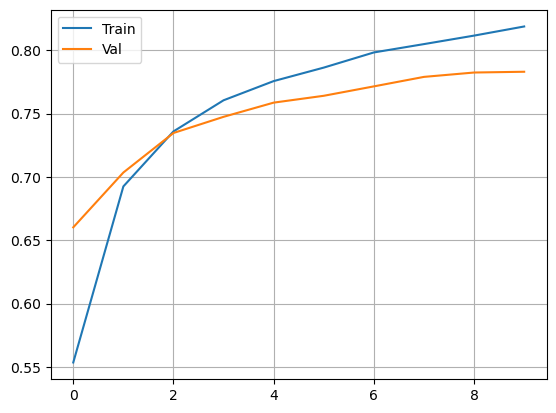

In [79]:
def plot_keras(hist, metr='accuracy'):
    h = hist.history
    x = range(len(h[metr]))
    plt.plot(x, h[metr], label='Train')
    plt.plot(x, h['val_'+metr], label='Val')
    plt.legend()
    plt.grid()
    plt.show()

plot_keras(history)

In [80]:
model.save('../bin/keras_1')

INFO:tensorflow:Assets written to: ../bin/keras_1\assets


INFO:tensorflow:Assets written to: ../bin/keras_1\assets
